In [17]:
from utils import *
from fluxtower_parse import *
from eddy_flux import * 
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows


In [18]:
# Get Metek data

# If metek files don't already exsist, extract using the below:

# To update raw data files: 
# rsync -azvp fluxtower@192.168.1.211:/home/data/fluxtower_data_transfer/ /Users/heather/ICECAPS-ACE/Data/.

# To extract metek files:
dname = '1908*.metek1'
dloc = '/Users/heather/ICECAPS-ACE/Data/Flux_compressed'
extract_out = '/Users/heather/ICECAPS-ACE/Data/'
#extract_tar(dloc,extract_out,dname)

# If extracted files already exist, just give the d loction:
dpath = '/Users/heather/ICECAPS-ACE/Data/'
log_metek = '/Users/heather/ICECAPS-ACE/log_metek.txt'

# Start and stop date:
start = dt.datetime(2019,8,1,16,0)
stop = dt.datetime(2019,8,30,16,0)

# Parse data into dataframe using the following function from fluxtower parse:
m1_orig,m2_orig = extract_metek_data(start,stop,dpath,log_metek)

Data error with 190809_180000.00.metek1


In [19]:
# Get Licor data
# If licor files don't already exsist, extract using the below:
# To update raw data files: 
# rsync -azvp fluxtower@192.168.1.211:/home/data/fluxtower_data_transfer/ /Users/heather/ICECAPS-ACE/Data/.

# To extract licor files:
#dname = 'licor'
#dloc = '/Users/heather/ICECAPS-ACE/Data/FLUX_compressed/'
#extract_out = '/Users/heather/ICECAPS-ACE/temp_data/'
#extract_tar(dloc,extract_out,dname)

# If extracted files already exist, just give the d loction:
dpath = '/Users/heather/ICECAPS-ACE/temp_data/home/data/'
log_licor = '/Users/heather/ICECAPS-ACE/log_licor.txt'

licor = extract_licor_data(start,stop,dpath,log_licor)

Skipping line 1073: expected 10 fields, saw 12

Skipping line 27094: expected 10 fields, saw 11

Skipping line 22565: expected 10 fields, saw 13



In [ ]:
# Clean metek data
m1 = clean_metek(m1_orig)
m2 = clean_metek(m2_orig)

In [ ]:
# Cross-wind temperature correction
m1['T'] = Ts_sidewind_correction(m1['T'].astype(float),m1['x'].astype(float),m1['y'].astype(float),m1['z'].astype(float))
m2['T'] = Ts_sidewind_correction(m2['T'].astype(float),m2['x'].astype(float),m2['y'].astype(float),m2['z'].astype(float))

In [ ]:
# Rotate to average streamline for each 15 minute period. 
avp=15                                              # Averaging period in minutes
m_rot = rotate_to_run(m1,avp)

In [ ]:
# Calculate cospectral density and ogive function for each 15 minute period.. 
x = m_rot['w']
y = m_rot['u']
sf = 10.0 # Sampling frequency
f,Csdxy,ogive = ogive(x, y, sf,avp)

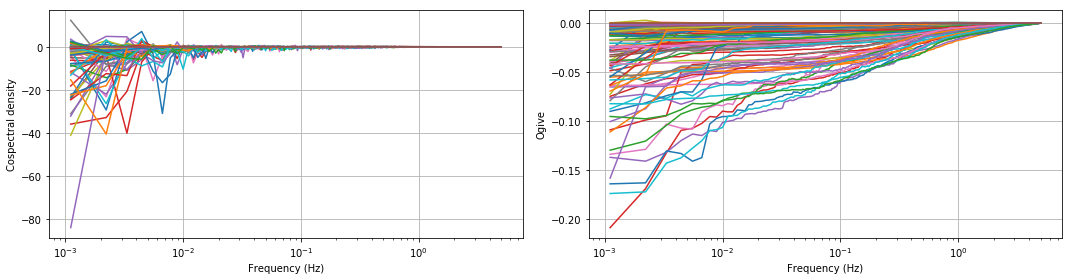

In [ ]:
# Plot co spectral density and ogive function.

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.grid(True)
for i in range(0,len(f)):
    ax1.semilogx(f[i],Csdxy[i],label='cospectra')
ax1.set_ylabel('Cospectral density')
ax1.set_xlabel('Frequency (Hz)')
#ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(True)
for i in range(0,len(f)):
    ax2.semilogx(f[i],ogive[i],label='ogive function')
ax2.set_ylabel('Ogive')
ax2.set_xlabel('Frequency (Hz)')
#ax2.legend()

#ax.set_xlim(d1,d2)
fig.tight_layout()



In [ ]:

# Calculate sensible heat flux. 

w = m_rot['w']
T = m_rot['T']

SHF,std=shf(w,T,avp)



In [ ]:
# Calculate latent heat flux
T = licor['T']
P = licor['P']
Nconc = licor['H2OD']
w = m_rot['w']
LHF = lhf(w,T,P,Nconc,avp)

KeyError: Timestamp('2019-08-07 17:00:00', freq='15T')

In [ ]:

# Plot fluxes

plot_times = pd.date_range(m_rot.index[0],m_rot.index[-1],freq='15min')

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(plot_times,SHF)
ax1.set_ylabel('SHF W/m2')
ax1.axhline(0)
#ax1.set_xlabel('Frequency (Hz)')
#ax1.legend()

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(plot_times,LHF)
ax2.set_ylabel('LHF W/m2')
ax2.axhline(0)
#ax1.set_xlabel('Frequency (Hz)')
#ax1.legend()

#ax.set_xlim(d1,d2)
fig.tight_layout()




In [ ]:
# Use snow depth sensor to do absolute height correction

In [ ]:
# Calculate bulk richardson number
#Ri = richardson number
#Rig = gradient richardson number: 
#       provides a measure of the balance between shear and bouyant forces 
#       and the resultant turbulent state of the atmosphere, based on mean 
#       wind and thermodynamic profiles. Negative Rig is an indication of 
#       buoyancy-generated turbulence, positive values are associated with 
#       stably stratified turbulence.
# For simplicity, generally refer to Rig>1 as nonturbulent. 

# Rig = g/thetaV * (dthetaV/dz) / ((du**2/dz + dv**2/dz))
# thetaV = virtual potential temperature

# Approximate thetav with theta (potential temperature) for now. 
Rd = 287.0 # J/K/kg - gas constant of 1kg of dry air
P0 = 100000.0 # Standard reference pressure, Pa

# theta = T(P0/P)**(Rd/cp)


